In [1]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 64
EPOCHS = 5          # CPU-friendly
LEARNING_RATE = 1e-3


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/local/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/anniherrmann/AIEngineering/AIEngineering/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  Fi

In [2]:
import sys
import os
from os.path import join
sys.path.append(os.path.abspath(".."))
from src.utils.preprocessing import preprocess_pipeline
from os.path import join
from src.data.mnist_loader import MnistDataloader

input_path = "../data"

mnist = MnistDataloader(
    join(input_path, "train-images-idx3-ubyte/train-images-idx3-ubyte"),
    join(input_path, "train-labels-idx1-ubyte/train-labels-idx1-ubyte"),
    join(input_path, "t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"),
    join(input_path, "t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte"),
)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Training data (with augmentation)
x_train_prep, y_train_prep = preprocess_pipeline(
    x_train, y_train, augment=True
)

# Test data (no augmentation)
x_test_prep, y_test_prep = preprocess_pipeline(
    x_test, y_test, augment=False
)

In [6]:
import torch
from torch.utils.data import TensorDataset

x_train_tensor = torch.tensor(x_train_prep, dtype=torch.float32)  # shape (N, 1, 28, 28)
y_train_tensor = torch.tensor(y_train_prep, dtype=torch.long)     # shape (N,)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)


x_test_tensor = torch.tensor(x_test_prep, dtype=torch.float32)  # shape (N, 1, 28, 28)
y_test_tensor = torch.tensor(y_test_prep, dtype=torch.long)     # shape (N,)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)


In [7]:
from torch.utils.data import TensorDataset, DataLoader


train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [ ]:
from src.models.cnn import MNISTCNN
from src.training.engine import train_one_epoch, evaluate
import torch.nn as nn
import torch.optim as optim

model = MNISTCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
import wandb

wandb.init(
    project="mnist-cnn",
    config={
        "epochs": 5,
        "batch_size": 64,
        "learning_rate": 0.001,
        "optimizer": "Adam",
        "loss": "CrossEntropy",
        "architecture": "MNISTCNN"
    }
)

config = wandb.config

In [10]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, DEVICE
    )

    test_loss, test_acc = evaluate(
        model, test_loader, criterion, DEVICE
    )

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Test Acc: {test_acc:.4f}"
    )
        # Log to W&B
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": test_loss,
        "val_accuracy": test_acc
    })

    print(
        f"Epoch {epoch+1}/{config.epochs} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {test_acc:.4f}"
    )
    wandb.watch(model, log="all", log_freq=100)

Epoch 1/5 | Train Loss: 0.2324, Train Acc: 0.9279 | Test Acc: 0.9891
Epoch 2/5 | Train Loss: 0.0907, Train Acc: 0.9736 | Test Acc: 0.9903
Epoch 3/5 | Train Loss: 0.0661, Train Acc: 0.9800 | Test Acc: 0.9917
Epoch 4/5 | Train Loss: 0.0521, Train Acc: 0.9841 | Test Acc: 0.9923
Epoch 5/5 | Train Loss: 0.0438, Train Acc: 0.9866 | Test Acc: 0.9913


In [13]:
import os
import torch

# Create folder if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save model weights
torch.save(model.state_dict(), "models/mnist_cnn.pth")



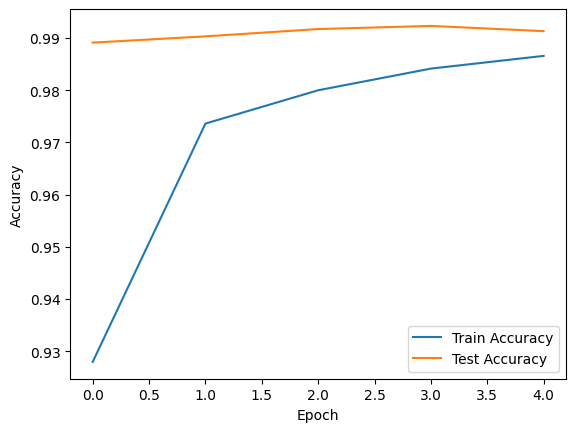

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [16]:
!wandb sweep sweep.yaml


wandb: Creating sweep from: sweep.yaml
wandb: Creating sweep with ID: o622akoq
wandb: View sweep at: https://wandb.ai/herrmann-ann-kathrin-universit-t-mannheim/AIEngineering/sweeps/o622akoq
wandb: Run sweep agent with: wandb agent herrmann-ann-kathrin-universit-t-mannheim/AIEngineering/o622akoq


In [17]:
!wandb agent herrmann-ann-kathrin-universit-t-mannheim/AIEngineering/o622akoq

wandb: Starting wandb agent 🕵️
2025-12-19 11:51:10,205 - wandb.wandb_agent - INFO - Running runs: []
2025-12-19 11:51:11,226 - wandb.wandb_agent - INFO - Agent received command: run
2025-12-19 11:51:11,227 - wandb.wandb_agent - INFO - Agent starting run with config:
	batch_size: 64
	epochs: 10
	learning_rate: 0.000661869850286105
2025-12-19 11:51:11,230 - wandb.wandb_agent - INFO - About to run command: /usr/bin/env python  --batch_size=64 --epochs=10 --learning_rate=0.000661869850286105
/Users/anniherrmann/AIEngineering/AIEngineering/.venv/bin/python: can't find '__main__' module in '/Users/anniherrmann/AIEngineering/AIEngineering/notebooks/'
2025-12-19 11:51:16,254 - wandb.wandb_agent - INFO - Running runs: ['9bvbtsfm']
2025-12-19 11:51:16,256 - wandb.wandb_agent - INFO - Cleaning up finished run: 9bvbtsfm
2025-12-19 11:51:16,959 - wandb.wandb_agent - INFO - Agent received command: run
2025-12-19 11:51:16,959 - wandb.wandb_agent - INFO - Agent starting run with config:
	batch_size: 6